# Import libraries

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score

import tensorflow as tf

In [2]:
# Set random seed
np.random.seed(21)
tf.random.set_seed(21)

In [3]:
# The hidden code cell limits the output height in colab.
from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

# Load Dataset

The data set used to train the model is [Titanic Dataset](https://www.kaggle.com/competitions/titanic/data) that has been processed in file `data_preprocessing.ipynb`.

In [4]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/Final Exam ML/datasets/cleaned-data/data_v2/train.csv', index_col='PassengerId')
val_df = pd.read_csv('/content/drive/MyDrive/Final Exam ML/datasets/cleaned-data/data_v2/val.csv', index_col='PassengerId')
test_df = pd.read_csv('/content/drive/MyDrive/Final Exam ML/datasets/cleaned-data/data_v2/test.csv', index_col='PassengerId')

In [6]:
train_df.shape, val_df.shape, test_df.shape

((712, 8), (179, 8), (418, 7))

In [7]:
numerical_features = ['Age', 'Fare', 'FamilySize']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title_Name']

features = numerical_features + categorical_features

# Logistic Regression with TensorFlow

In this section use [TensorFlow Core APIs](https://www.tensorflow.org/guide/core) to perform binary classification with Logistic Regression.

## Define Model and Functions

In [8]:
# The log loss function
def log_loss(y_pred, y):
  # Compute the log loss function
  ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(ce)

In [9]:
# Logistic Regression Model
class TF_LogisticRegression(tf.Module):

  def __init__(self):
    self.built = False

  def __call__(self, x, train=True):
    # Initialize the model parameters on the first call
    if not self.built:
      # Randomly generate the weights and the bias term
      rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
      rand_b = tf.random.uniform(shape=[], seed=22)
      self.w = tf.Variable(rand_w)
      self.b = tf.Variable(rand_b)
      self.built = True
    # Compute the model output
    z = tf.add(tf.matmul(x, self.w), self.b)
    z = tf.squeeze(z, axis=1)
    if train:
      return z
    return tf.sigmoid(z)

In [10]:
def predict_class(y_pred, thresh=0.5):
  # Return a tensor with  `1` if `y_pred` >= `0.5`, and `0` otherwise
  return tf.cast(y_pred >= thresh, tf.float32)

def compute_accuracy(y_pred, y):
  # Return the proportion of matches between `y_pred` and `y`
  y_pred = tf.math.sigmoid(y_pred)
  y_pred_class = predict_class(y_pred)
  check_equal = tf.cast(y_pred_class == y,tf.float32)
  acc_val = tf.reduce_mean(check_equal)
  return acc_val

## Preprocess the data

In [11]:
# Extract features and Label
X_train = train_df[features]
y_train = train_df['Survived']

X_val = val_df[features]
y_val = val_df['Survived']

X_test = test_df[features]

In [12]:
# Create transformers for categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

# Fit and transform the training data
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [13]:
# Convert to tensor
X_train, y_train = tf.convert_to_tensor(X_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
X_val, y_val = tf.convert_to_tensor(X_val, dtype=tf.float32), tf.convert_to_tensor(y_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

## Training Model

In [14]:
# Set training parameters
epochs = 200
learning_rate = 0.01
train_losses, val_losses = [], []
train_accs, val_accs = [], []

batch_size = 8

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=X_train.shape[0]).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.shuffle(buffer_size=X_val.shape[0]).batch(batch_size)

In [15]:
%set_cell_height 300

# Define Model
log_reg = TF_LogisticRegression()

# Set up the training loop and begin training
for epoch in range(epochs):
  batch_losses_train, batch_accs_train = [], []
  batch_losses_test, batch_accs_test = [], []

  # Iterate over the training data
  for x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = log_reg(x_batch)
      batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = compute_accuracy(y_pred_batch, y_batch)
    # Update the parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, log_reg.variables)
    for g,v in zip(grads, log_reg.variables):
      v.assign_sub(learning_rate * g)
    # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  # Iterate over the testing data
  for x_batch, y_batch in val_dataset:
    y_pred_batch = log_reg(x_batch)
    batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = compute_accuracy(y_pred_batch, y_batch)
    # Keep track of batch-level testing performance
    batch_losses_test.append(batch_loss)
    batch_accs_test.append(batch_acc)

  # Keep track of epoch-level model performance
  train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
  val_loss, val_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

  print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")

<IPython.core.display.Javascript object>

Epoch: 0, Training log loss: 1.391
Epoch: 1, Training log loss: 0.888
Epoch: 2, Training log loss: 0.676
Epoch: 3, Training log loss: 0.583
Epoch: 4, Training log loss: 0.536
Epoch: 5, Training log loss: 0.509
Epoch: 6, Training log loss: 0.492
Epoch: 7, Training log loss: 0.481
Epoch: 8, Training log loss: 0.472
Epoch: 9, Training log loss: 0.465
Epoch: 10, Training log loss: 0.460
Epoch: 11, Training log loss: 0.455
Epoch: 12, Training log loss: 0.452
Epoch: 13, Training log loss: 0.449
Epoch: 14, Training log loss: 0.446
Epoch: 15, Training log loss: 0.444
Epoch: 16, Training log loss: 0.442
Epoch: 17, Training log loss: 0.441
Epoch: 18, Training log loss: 0.439
Epoch: 19, Training log loss: 0.438
Epoch: 20, Training log loss: 0.437
Epoch: 21, Training log loss: 0.436
Epoch: 22, Training log loss: 0.435
Epoch: 23, Training log loss: 0.434
Epoch: 24, Training log loss: 0.433
Epoch: 25, Training log loss: 0.432
Epoch: 26, Training log loss: 0.431
Epoch: 27, Training log loss: 0.431
Ep

## Performance Evaluation

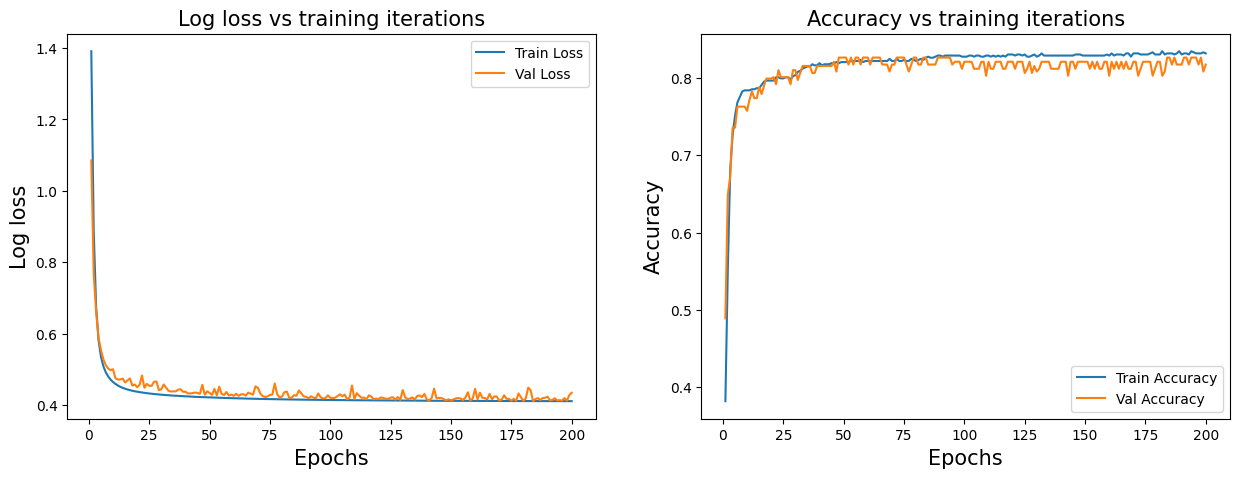

In [16]:
# Plot history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
lstEpoch = [i+1 for i in range(epochs)]

ax1.set_title("Log loss vs training iterations", fontsize=15)
ax1.plot(lstEpoch, train_losses)
ax1.plot(lstEpoch, val_losses)
ax1.set_xlabel("Epochs", fontsize=15)
ax1.set_ylabel("Log loss",fontsize=15)
ax1.legend(title="", labels=["Train Loss","Val Loss"])

ax2.set_title("Accuracy vs training iterations", fontsize=15)
ax2.plot(lstEpoch, train_accs)
ax2.plot(lstEpoch, val_accs)
ax2.set_xlabel("Epochs",fontsize=15)
ax2.set_ylabel("Accuracy",fontsize=15)
ax2.legend(title="", labels=["Train Accuracy","Val Accuracy"])

plt.show()

**Remarks**

**1. Log Loss Plot**
- The training and validation loss both decrease steadily and converge to low values as the number of epochs increases.
- The validation loss curve is slightly noisier but shows no significant overfitting, as it closely follows the training loss.
- This indicates that the model is well-trained and generalizes well to unseen data.

**2. Accuracy Plot**
- Both training and validation accuracy increase quickly during the initial epochs, reaching a plateau at around 80–83%.
- The validation accuracy closely follows the training accuracy, showing good generalization without signs of overfitting.
- The small oscillations in the validation accuracy are normal and suggest some sensitivity to the validation dataset but are not problematic.

**Summary:** The model training appears successful with no signs of severe overfitting or underfitting. The performance on the validation set is consistent with the training set, indicating a well-balanced model.

In [17]:
print(f"Final train log loss: {train_losses[-1]:.3f}")
print(f"Final val log Loss: {val_losses[-1]:.3f}")

print(f"Final train accuracy: {train_accs[-1]:.3f}")
print(f"Final val accuracy: {val_accs[-1]:.3f}")

Final train log loss: 0.411
Final val log Loss: 0.435
Final train accuracy: 0.831
Final val accuracy: 0.817


In [18]:
y_pred_val = log_reg(X_val, train=False)
val_classes = predict_class(y_pred_val)

In [19]:
print(classification_report(y_true=y_val.numpy(), y_pred=val_classes.numpy()))

              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86       110
         1.0       0.79      0.72      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



In [20]:
# Save the results for future comparison.
val_results = {}

val_results["tf_model"] = [
    accuracy_score(y_val.numpy(), val_classes.numpy()),
    precision_score(y_val.numpy(), val_classes.numpy()),
    recall_score(y_val.numpy(), val_classes.numpy()),
    f1_score(y_val.numpy(), val_classes.numpy())
]

# Logistic Regression with Scikit-learn

Use [Scikit-learn](https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.LogisticRegression.html) library to build Logistic Regression model with default hyperparameters.

In [21]:
# Extract features and Label
X_train = train_df[features]
y_train = train_df['Survived']

X_val = val_df[features]
y_val = val_df['Survived']

X_test = test_df[features]

In [22]:
# Create a Preprocessing Pipeline
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [23]:
# Define and Train the Logistic Regression Model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Fare',
                                                   'FamilySize']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'Title_Name'])])),
                ('classifier', LogisticRegression())])

In [24]:
y_pred = model.predict(X_val)

In [25]:
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")

Accuracy: 0.8435754189944135


In [26]:
print(classification_report(val_df['Survived'], y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88       110
           1       0.83      0.75      0.79        69

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



In [27]:
# Save the results
val_results["default_model"] = [
    accuracy_score(y_val, y_pred),
    precision_score(y_val, y_pred),
    recall_score(y_val, y_pred),
    f1_score(y_val, y_pred)
]

# Hyperparameter Tuning with GridSearchCV

Using [GridSearchCV](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html) to perform hyperparameter tuning for a Logistic Regression model with the hyperparameters:
- **C:** Inverse of regularization strength, controls the strength of regularization in Logistic Regression.
- **class_weight:** Adjusts the importance (or weight) of each class when computing the loss function. Because the dataset is ***imbalanced***.
- **solver:** Determines the optimization algorithm used to minimize the loss function during training.
- **max_iter:** The maximum number of iterations the solver will run during optimization.

In [28]:
# Extract features and Label
X_train = train_df[features]
y_train = train_df['Survived']

X_val = val_df[features]
y_val = val_df['Survived']

In [29]:
gr_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

gr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-4, 4, 30),
    'classifier__class_weight': [None, 'balanced'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [100, 1000, 10000]
}

In [30]:
# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=gr_pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

In [31]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Fare',
                                                                          'FamilySize']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Pclass',
                                                                          'Sex',
                                                                          'Embarked',
                                                                          'Title_Name'])])),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'classifier__C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.7233575...
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'classifier__class_weight': [None, 'balanced'],
                         'classifier__max_iter': [100, 1000, 10000],
                         'classifier__solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=2)

In [32]:
# Best hyperparameters and corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'classifier__C': 4.893900918477489, 'classifier__class_weight': None, 'classifier__max_iter': 100, 'classifier__solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.8245149216980202


In [33]:
# C=4.893900918477489, class_weight=None, max_iter=100, solver='liblinear'

In [34]:
best_model = grid_search.best_estimator_
gr_y_pred = best_model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, gr_y_pred))

Accuracy: 0.8491620111731844


In [35]:
# Save the results
val_results["best_model"] = [
    accuracy_score(y_val, gr_y_pred),
    precision_score(y_val, gr_y_pred),
    recall_score(y_val, gr_y_pred),
    f1_score(y_val, gr_y_pred)
]

# Evaluating Classification Model

In [36]:
result_df = pd.DataFrame.from_dict(val_results, orient='index', columns=['Accuracy','Precision','Recall','F1-score'])
result_df

,Accuracy,Precision,Recall,F1-score
tf_model,0.821229,0.793651,0.724638,0.757576
default_model,0.843575,0.825397,0.753623,0.787879
best_model,0.849162,0.828125,0.768116,0.796992


**Remarks:** Based on the above results, the performance of `best_model` is the best among the three models. Therefore, evaluations will be performed on `best_model` or the model with adjusted hyperparameters.

## Confusion Matrix

In [37]:
def show_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, normalize: bool=False) -> None:
  """

  """
  # Compute the confusion matrix and normalize it
  plt.figure(figsize=(5,5))
  confusion = confusion_matrix(y_true, y_pred)

  axis_labels = range(2)

  if normalize:
    confusion = confusion / confusion.sum(axis=1, keepdims=True)
    ax = sns.heatmap(
        confusion, xticklabels=axis_labels, yticklabels=axis_labels,
        cmap='Blues', annot=True, fmt='.4f', square=True, vmin=0, vmax=1)
  else:
    ax = sns.heatmap(
        confusion, xticklabels=axis_labels, yticklabels=axis_labels,
        cmap='Blues', annot=True, fmt='d', square=True, vmin=0, vmax=len(y_pred))

  plt.title(f"Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

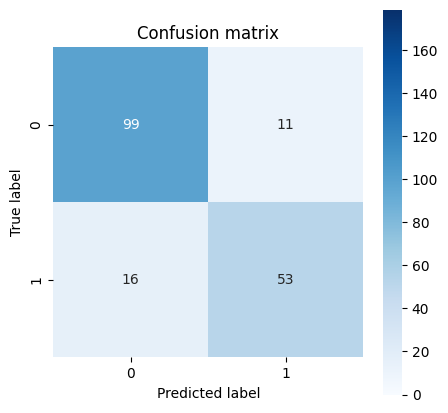

In [38]:
show_confusion_matrix(y_val, gr_y_pred)

In [39]:
y_val.value_counts()

,count
Survived,
0,110
1,69


**Remarks**
- **True Positives (TP):** 53/69 instances of Class 1 were correctly predicted as Class 1.
- **True Negatives (TN):** 99/110 instances of Class 0 were correctly predicted as Class 0.
- **False Positives (FP):** 11 instances of Class 0 were incorrectly predicted as Class 1 (Type I error).
- **False Negatives (FN):** 16 instances of Class 1 were incorrectly predicted as Class 0 (Type II error).

**Summary:** The model appears better at detecting Class 0 than Class 1 because it is affected by the imbalance between the two classes.

## Classification Report

In [40]:
print(classification_report(y_val, gr_y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       110
           1       0.83      0.77      0.80        69

    accuracy                           0.85       179
   macro avg       0.84      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179



**Remarks**

**1. Performance across classes**
- **Class 0 (No Survived)**
  - Precision: 0.86 indicates that 86% of predicted Class 0 samples were correctly classified.
  - Recall: 0.90 indicates that 90% of actual Class 0 samples were identified correctly.
  - F1-score: 0.88 is a good balance between precision and recall, showing strong performance for this class.
- **Class 1 (Survived)**
  - Precision: 0.83 indicates that 83% of predicted Class 1 samples were correctly classified.
  - Recall: 0.77 indicates that 77% of actual Class 1 samples were identified correctly.
  - F1-score: 0.80 suggests decent but weaker performance for Class 1 compared to Class 0.

The support shows that Class 0 (110 samples) is more frequent than Class 1 (69 samples), which might explain the slightly lower recall and F1-score for Class 1.

**2. Overall Metrics**
- Accuracy: 85% of total samples were classified correctly, showing the model performs fairly well overall.
- Macro Avg: Precision, Recall, and F1-Score are approximately 0.83-0.84, indicating balanced performance across classes without being influenced by class imbalance.
- Weighted Avg: Precision, Recall, and F1-Score are 0.85, emphasizing that Class 0 (with higher support) contributes more to the overall performance.

## ROC Curve and AUC Scores

AUC: 0.876


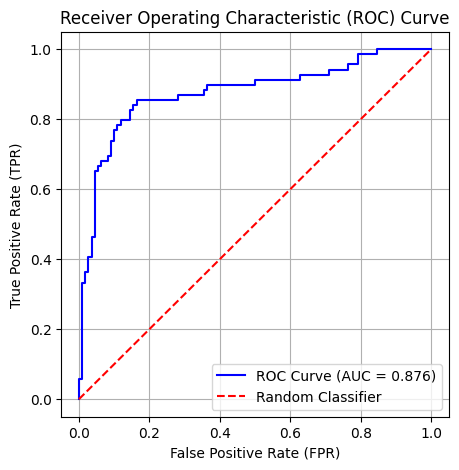

In [41]:
# # Predict probabilities for the positive class
y_pred_proba = best_model.predict_proba(X_val)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

# Calculate AUC
auc = roc_auc_score(y_val, y_pred_proba)
print(f"AUC: {auc:.3f}")

# Plot ROC Curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Classifier")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

**Remarks**
- **Area Under the Curve (AUC):** The AUC value is 0.876, which indicates good classification performance. A value of 1 represents perfect performance, while 0.5 suggests no discriminatory power (equivalent to random guessing).
- **True Positive Rate (TPR) vs. False Positive Rate (FPR):** The curve stays close to the top-left corner, indicating a high true positive rate with a relatively low false positive rate for most thresholds.

**Summary:** The red dashed line represents the performance of a random classifier (AUC = 0.5). The curve is well above this line, confirming that the model performs significantly better than random guessing. So,  the model is effective at distinguishing between the two classes.

In [42]:
result_metrics_df = pd.read_csv("/content/drive/MyDrive/Final Exam ML/source codes/result_metrics.csv")

# Save results for comparison between models
from sklearn.metrics import precision_score, recall_score, f1_score

new_row = pd.DataFrame({
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_val, gr_y_pred),
    'Precision': precision_score(y_val, gr_y_pred),
    'Recall': recall_score(y_val, gr_y_pred),
    'F1-Score': f1_score(y_val, gr_y_pred)
}, index=[len(result_metrics_df)])

result_metrics_df = pd.concat([result_metrics_df, new_row], ignore_index=True)

result_metrics_df

,Model,Accuracy,Precision,Recall,F1-Score
0,CART,0.821229,0.862745,0.637681,0.733333
1,Random Forest,0.815642,0.800000,0.695652,0.744186
2,Naive Bayes,0.793296,0.750000,0.695652,0.721805
3,SVM,0.843575,0.825397,0.753623,0.787879
4,AdaBoost,0.815642,0.772727,0.739130,0.755556
5,GradientBoost,0.810056,0.777778,0.710145,0.742424
6,Logistic Regression,0.849162,0.828125,0.768116,0.796992


In [43]:
result_metrics_df.to_csv('/content/drive/MyDrive/Final Exam ML/source codes/result_metrics.csv', index=False)